In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import csv
from matplotlib import pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import  MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data load

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
print(train.shape, test.shape)

(1460, 81) (1459, 80)


In [4]:
train['group'] = 'Train'
test['group'] = 'Test'
test['SalePrice'] = -1
data = train.append(test).drop(columns='Id')
data.reset_index(drop = True, inplace=True)

# Preliminary data analysis

### Target feature

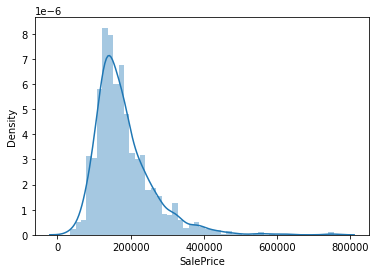

In [5]:
sns.distplot(data[data.group=='Train']['SalePrice']);
# Based on visual distribution, skewness and RMSLE metric we can try
# to apply log scaling for better model results 

In [6]:
mean = data['SalePrice'].mean()
std = data['SalePrice'].std()
skew = data['SalePrice'].skew()
print('SalePrice : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

SalePrice : mean: 90491.0884, std: 106496.8042, skew: 1.0993


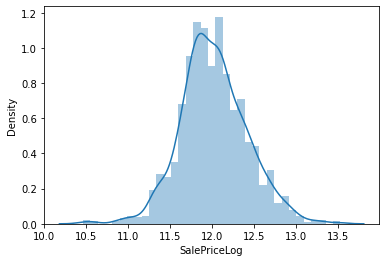

In [7]:
data['SalePriceLog'] = np.log1p(data['SalePrice'])
sns.distplot(data[data.group=='Train']['SalePriceLog']);
# looks more like a normal distribution now

### House features

In [8]:
data

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice  group  SalePriceLog
0             60       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2003          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd        TA      PConc       Gd       TA           No          GLQ       706.0          Unf         0.0      150.0        856.0    GasA        Ex          Y      SBrkr       856       854             0       1710           1.0           0.0         2         1             3             1          Gd             8        Typ           0         NaN     Attchd       2003.0          RFn         2.0       548.0         TA         TA          Y           0           61              0          0            0         0    NaN    NaN         NaN        0       2    2008       WD        Normal     208500  Train     12.247699
1             20       RL         80.0     9600   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story            6            8       1976          1976     Gable  CompShg     MetalSd     MetalSd       None         0.0        TA        TA     CBlock       Gd       TA           Gd          ALQ       978.0          Unf         0.0      284.0       1262.0    GasA        Ex          Y      SBrkr      1262         0             0       1262           0.0           1.0         2         0             3             1          TA             6        Typ           1          TA     Attchd       1976.0          RFn         2.0       460.0         TA         TA          Y         298            0              0          0            0         0    NaN    NaN         NaN        0       5    2007       WD        Normal     181500  Train     12.109016
2             60       RL         68.0    11250   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2001          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA      PConc       Gd       TA           Mn          GLQ       486.0          Unf         0.0      434.0        920.0    GasA        Ex          Y      SBrkr       920       866             0       1786           1.0           0.0         2         1             3             1          Gd             6        Typ           1          TA     Attchd       2001.0          RFn         2.0       608.0         TA         TA          Y           0           42              0          0            0         0    NaN    NaN         NaN        0       9    2008       WD        Normal     223500  Train     12.317171
3             70       RL         60.0     9550   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story            7            5       1915          1970     Gable  CompShg     Wd Sdng     Wd Shng       None         0.0        TA        TA     BrkTil       TA       Gd          

In [9]:
data.describe()

MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea       MiscVal       MoSold       YrSold      SalePrice  SalePriceLog
count  2919.000000  2433.000000    2919.000000  2919.000000  2919.000000  2919.000000   2919.000000  2896.000000  2918.000000  2918.000000  2918.000000  2918.000000  2919.000000  2919.000000   2919.000000  2919.000000   2917.000000   2917.000000  2919.000000  2919.000000   2919.000000   2919.000000   2919.000000  2919.000000  2760.000000  2918.000000  2918.000000  2919.000000  2919.000000    2919.000000  2919.000000  2919.000000  2919.000000   2919.000000  2919.000000  2919.000000    2919.000000   2919.000000
mean     57.137718    69.305795   10168.114080     6.089072     5.564577  1971.312778   1984.264474   102.201312   441.423235    49.582248   560.772104  1051.777587  1159.581706   336.483727      4.694416  1500.759849      0.429894      0.061364     1.568003     0.380267      2.860226      1.044536      6.451524     0.597122  1978.113406     1.766621   472.874572    93.709832    47.486811      23.098321     2.602261    16.062350     2.251799     50.825968     6.213087  2007.792737   90491.088386          -inf
std      42.517628    23.344905    7886.996359     1.409947     1.113131    30.291442     20.894344   179.334253   455.610826   169.205611   439.543659   440.766258   392.362079   428.701456     46.396825   506.051045      0.524736      0.245687     0.552969     0.502872      0.822693      0.214462      1.569379     0.646129    25.574285     0.761624   215.394815   126.526589    67.575493      64.244246    25.188169    56.184365    35.663946    567.402211     2.714762     1.314964  106496.804191           NaN
min      20.000000    21.000000    1300.000000     1.000000     1.000000  1872.000000   1950.000000     0.000000     0.000000     0.000000     0.000000     0.000000   334.000000     0.000000      0.000000   334.000000      0.000000      0.000000     0.000000     0.000000      0.000000      0.000000      2.000000     0.000000  1895.000000     0.000000     0.000000     0.000000     0.000000       0.000000     0.000000     0.000000     0.000000      0.000000     1.000000  2006.000000      -1.000000          -inf
25%      20.000000    59.000000    7478.000000     5.000000     5.000000  1953.500000   1965.000000     0.000000     0.000000     0.000000   220.000000   793.000000   876.000000     0.000000      0.000000  1126.000000      0.000000      0.000000     1.000000     0.000000      2.000000      1.000000      5.000000     0.000000  1960.000000     1.000000   320.000000     0.000000     0.000000       0.000000     0.000000     0.000000     0.000000      0.000000     4.000000  2007.000000      -1.000000          -inf
50%      50.000000    68.000000    9453.000000     6.000000     5.000000  1973.000000   1993.000000     0.000000   368.500000     0.000000   467.000000   989.500000  1082.000000     0.000000      0.000000  1444.000000      0.000000      0.000000     2.000000     0.000000      3.000000      1.000000      6.000000     1.000000  1979.000000     2.000000   480.000000     0.000000    26.000000       0.000000     0.000000     0.000000     0.000000      0.000000     6.000000  2008.000000   34900.000000     10.460271
75%      70.000000    80.000000   11570.000000     7.000000     6.000000  2001.000000   2004.000000   164.000000   733.000000     0.000000   805.500000  1302.000000  1387.500000   704.000000      0.000000  1743.500000      1.000000      0.000000     2.000000     1.000000      3.000000      1.000000      7.000000     1.000000  2002.000000     2.000000   576.000000   168.000000    70.000000       0.000

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [11]:
nan_columns = data.columns[data.isnull().any()].tolist()
print(f'Columns with nan: {len(nan_columns)}')

for c in nan_columns:
    print(f'{c}, {data[c].isna().sum()} nan of {len(data)}\nunique values: \n{data[c].unique()} \n--------------------')

Columns with nan: 34
MSZoning, 4 nan of 2919
unique values: 
['RL' 'RM' 'C (all)' 'FV' 'RH' nan] 
--------------------
LotFrontage, 486 nan of 2919
unique values: 
[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.  26.
  25. 119.  31.  28. 117. 113. 125. 135. 136.  22. 123. 195. 155. 126.
 200. 131. 133.] 
--------------------
Alley, 2721 nan of 2919
unique values: 
[nan 'Grvl' 'Pave'] 
--------------------
Utilities, 2 nan of 2919
unique values: 
['AllPub' 'NoSeWa' nan] 
----------

### Nan replacement

In [12]:
data.MSZoning.fillna("RL", inplace = True)
data.LotFrontage.fillna(data.LotFrontage.mean(), inplace=True)
data.Alley.fillna("No", inplace = True)
data.Utilities.fillna('AllPub', inplace = True)
data.Exterior1st.fillna('VinylSd', inplace = True)
data.Exterior2nd.fillna('VinylSd', inplace = True)
data.MasVnrType.fillna('No', inplace = True)
data.MasVnrType.replace('None', 'No', inplace = True)
data.MasVnrArea.fillna(0., inplace=True)
data.BsmtCond.fillna("No", inplace=True)
data.BsmtQual.fillna("No", inplace=True)
data.BsmtExposure.fillna("No", inplace=True)
data.BsmtFinType1.fillna("No", inplace=True)
data.BsmtFinSF1.fillna(0., inplace=True)
data.BsmtFinType2.fillna("No", inplace=True)
data.BsmtFinSF2.fillna(0., inplace=True)
data.BsmtUnfSF.fillna(0., inplace=True)
data.TotalBsmtSF.fillna(0., inplace=True)
data.Electrical.fillna("SBrkr", inplace=True)
data.BsmtFullBath.fillna(0., inplace=True)
data.BsmtHalfBath.fillna(0., inplace=True)
data.KitchenQual.fillna("TA", inplace = True)
data.Functional.fillna('Typ', inplace = True)
data.FireplaceQu.fillna("No", inplace = True)
data.GarageType.fillna("No", inplace = True)
data.GarageYrBlt.fillna(0, inplace = True)
data.GarageFinish.fillna("No", inplace = True)
data.GarageCars.fillna(0, inplace = True)
data.GarageArea.fillna(0, inplace = True)
data.GarageQual.fillna("No", inplace = True)
data.GarageCond.fillna("No", inplace = True)
data.PoolQC.fillna("No", inplace = True)
data.Fence.fillna("No", inplace = True)
data.MiscFeature.fillna("No", inplace = True)
data.SaleType.fillna("WD", inplace = True)
data.SaleCondition.fillna("Normal", inplace = True)

In [13]:
data.isnull().sum().any()
# No nan in data

False

In [14]:
data.dtypes.value_counts()

object     44
int64      26
float64    12
dtype: int64

### Correlation matrix (may help to understand features relationships)

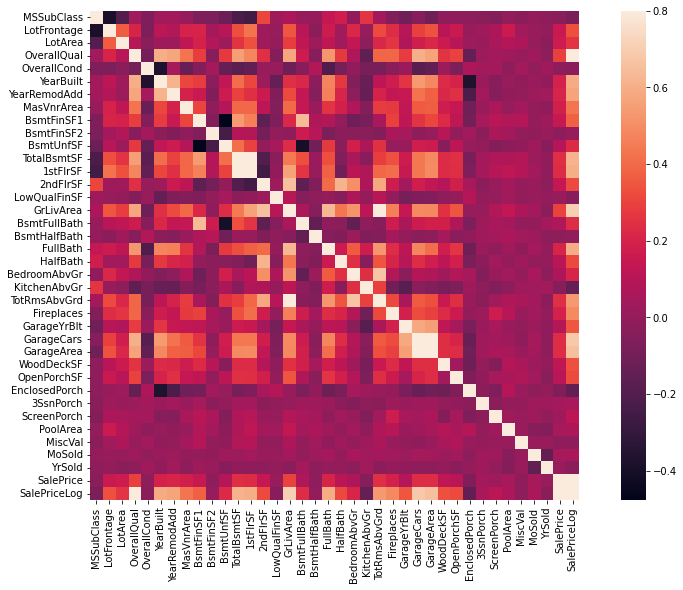

In [15]:
# not quite informative
corrmatrix = data.corr()
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corrmatrix, vmax=.8, square=True);

### Numerical variables

In [16]:
numerical_features = [col for col in data.loc[:,:'SaleCondition'].columns if 
                data[col].dtype in ['int64', 'float64']]

In [17]:
numerical_features

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

<Figure size 360x360 with 0 Axes>

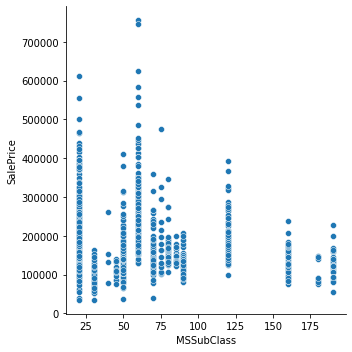

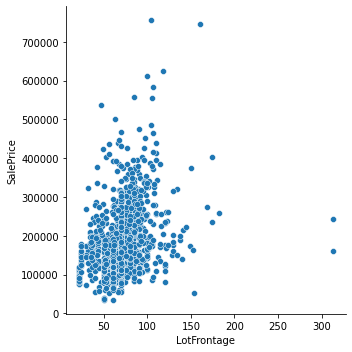

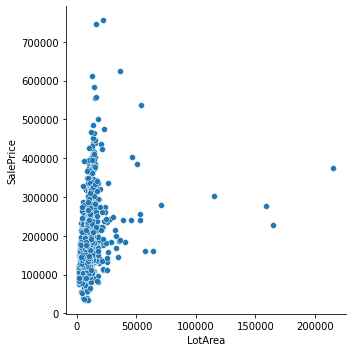

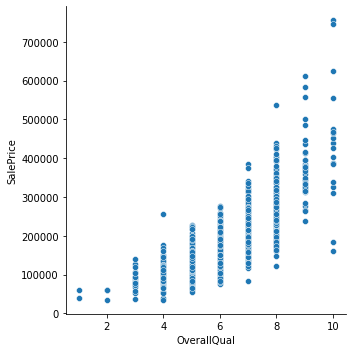

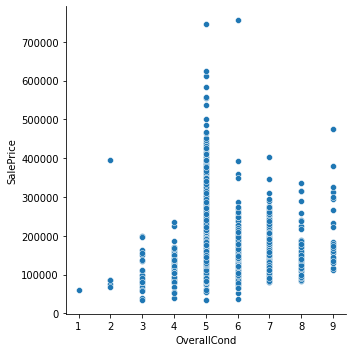

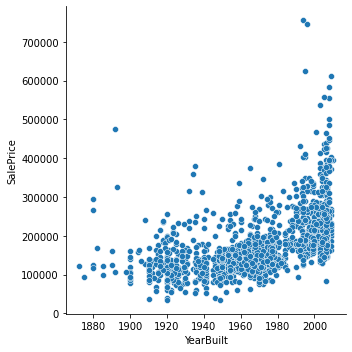

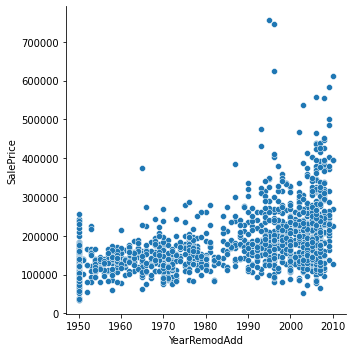

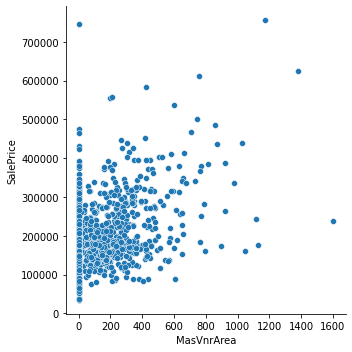

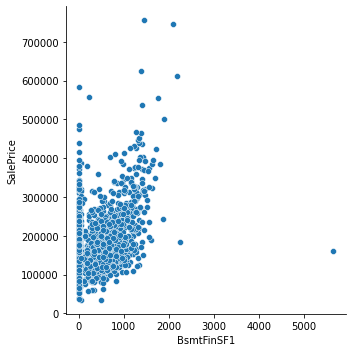

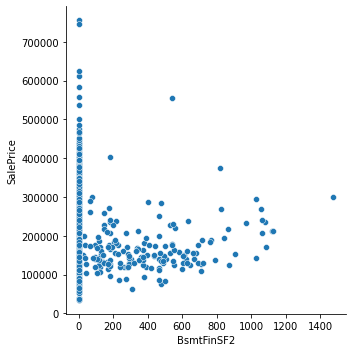

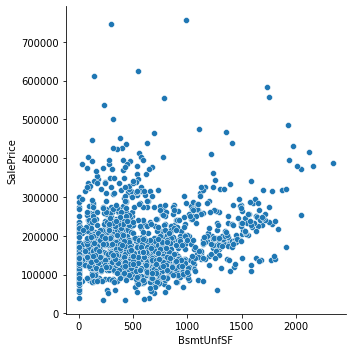

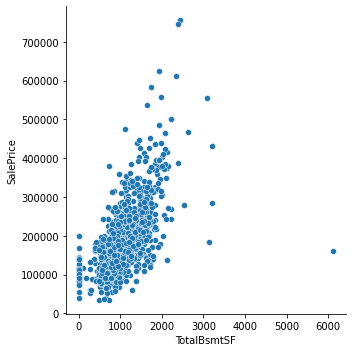

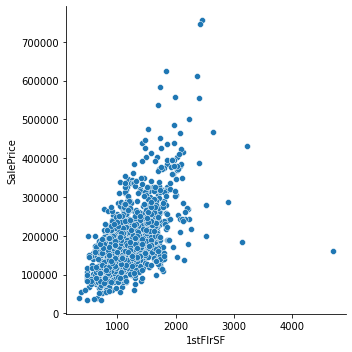

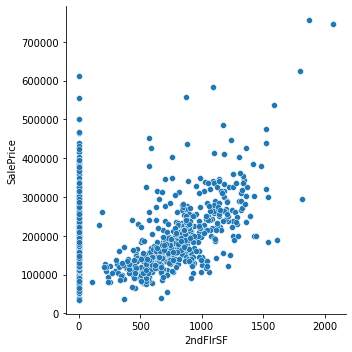

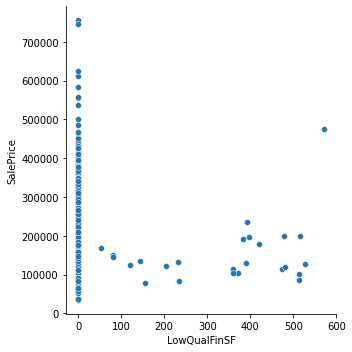

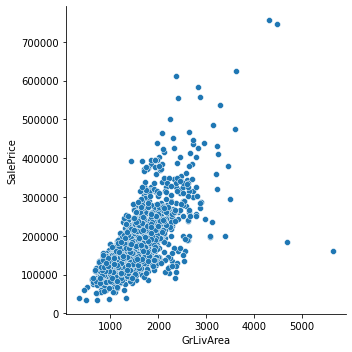

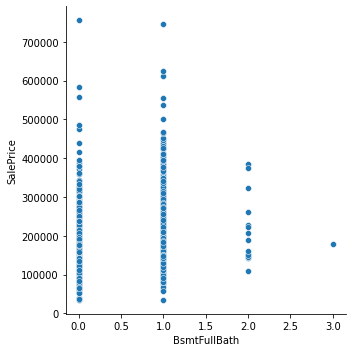

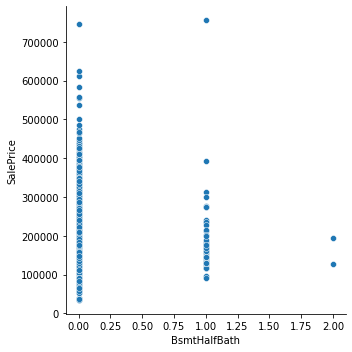

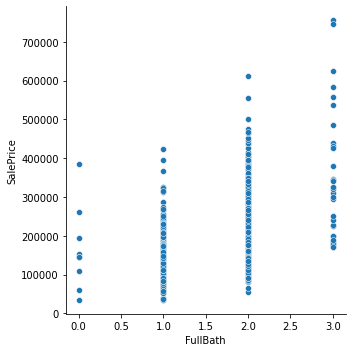

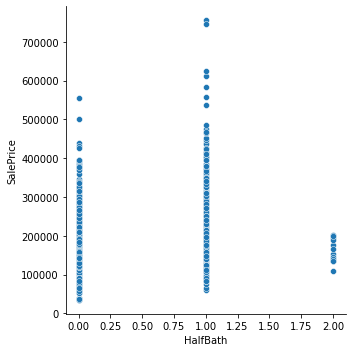

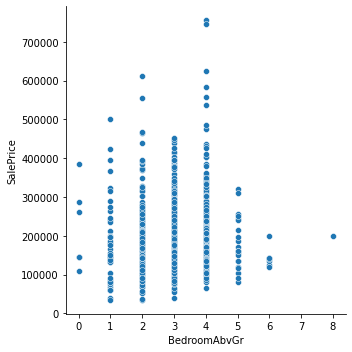

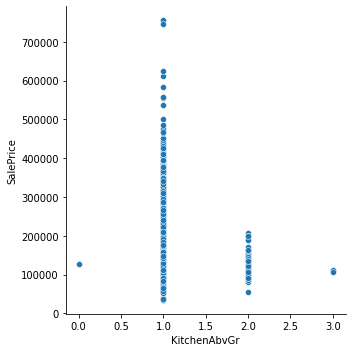

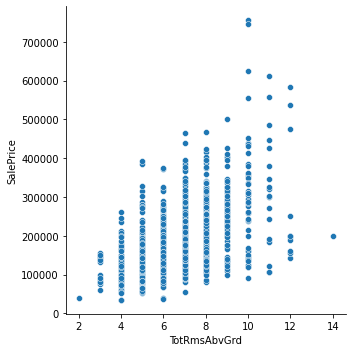

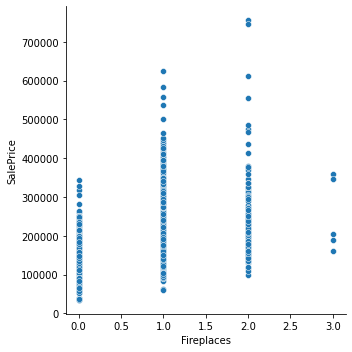

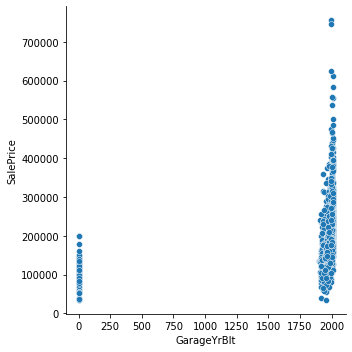

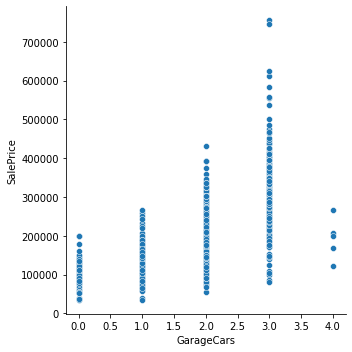

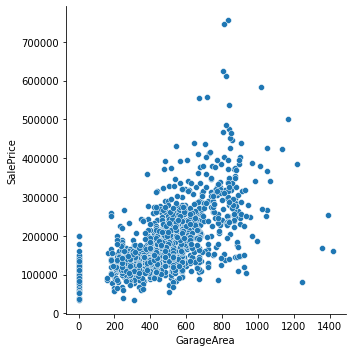

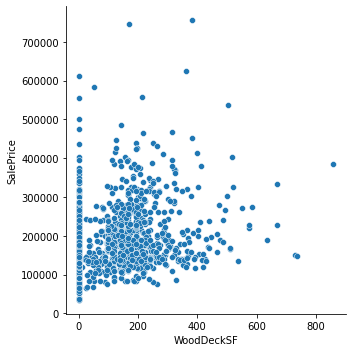

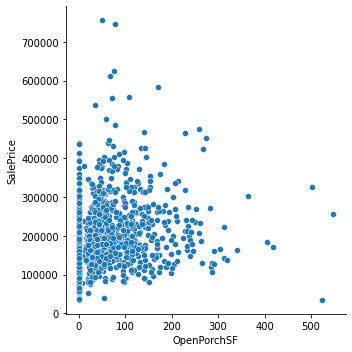

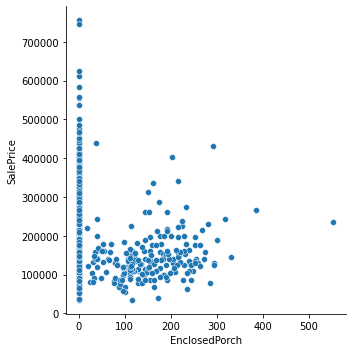

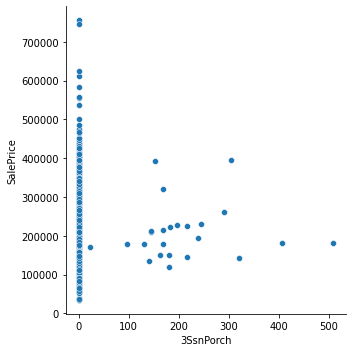

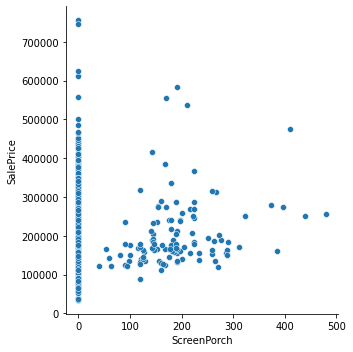

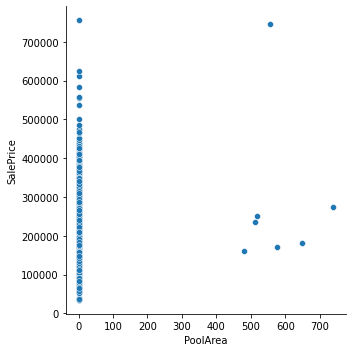

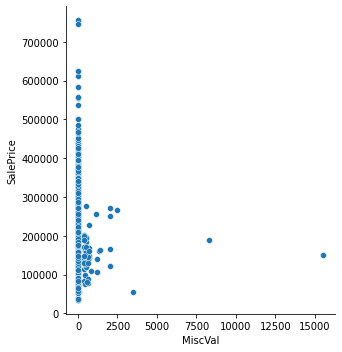

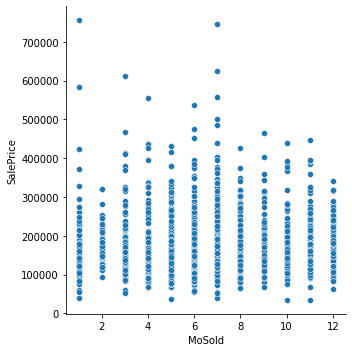

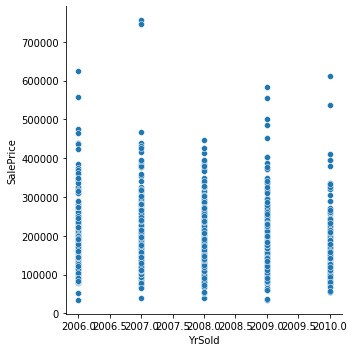

In [18]:
for idx, col in enumerate(numerical_features):
    plt.figure(idx, figsize=(5,5))
    sns.relplot(data = data[data.group == "Train"], x=col, y='SalePrice', kind="scatter", )
    plt.show

Let's try to get rid of multicollinearity and uninformative features with the help of MI score and XGBClassifier


In [19]:
train_data = data[data.group == "Train"]
train_data_numerical = train_data.loc[:,:'SaleCondition'][numerical_features]
train_data_target = train_data['SalePrice']

In [20]:
def mi_score(x,y):
    mi_score = mutual_info_regression(x,y, discrete_features=False, random_state=25)
    mi_score = pd.Series(mi_score, name="MI_SCORE", index=x.columns)
    mi_score = mi_score.sort_values(ascending=False)
    return mi_score

mi_results = mi_score(train_data_numerical,train_data_target)
pd.DataFrame(mi_results)

MI_SCORE
OverallQual    0.581117
GrLivArea      0.480730
GarageCars     0.367228
YearBuilt      0.366446
TotalBsmtSF    0.366361
GarageArea     0.358772
1stFlrSF       0.310176
MSSubClass     0.274037
FullBath       0.264581
GarageYrBlt    0.261164
YearRemodAdd   0.254248
LotFrontage    0.221421
TotRmsAbvGrd   0.221350
2ndFlrSF       0.203841
Fireplaces     0.157562
LotArea        0.156517
BsmtFinSF1     0.148202
OpenPorchSF    0.145075
BsmtUnfSF      0.119864
OverallCond    0.107489
HalfBath       0.105713
WoodDeckSF     0.104274
MasVnrArea     0.091976
BedroomAbvGr   0.072494
EnclosedPorch  0.027691
KitchenAbvGr   0.025917
ScreenPorch    0.020558
BsmtFullBath   0.013298
YrSold         0.011226
LowQualFinSF   0.008306
MiscVal        0.005243
BsmtHalfBath   0.003379
PoolArea       0.001082
3SsnPorch      0.000000
MoSold         0.000000
BsmtFinSF2     0.000000

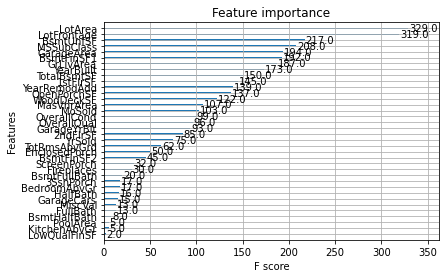

In [21]:
X = train_data_numerical
y = train_data_target
model = XGBRegressor()
model.fit(X, y)

importance = model.feature_importances_
plot_importance(model)
plt.rcParams["figure.figsize"] = (10,20)
plt.show();

In [22]:
list(zip(X.columns, model.feature_importances_))

[('MSSubClass', 0.00042275284),
 ('LotFrontage', 0.0019178279),
 ('LotArea', 0.0034004706),
 ('OverallQual', 0.53679),
 ('OverallCond', 0.004815914),
 ('YearBuilt', 0.004575074),
 ('YearRemodAdd', 0.0076701646),
 ('MasVnrArea', 0.0017710333),
 ('BsmtFinSF1', 0.011555732),
 ('BsmtFinSF2', 0.0011612017),
 ('BsmtUnfSF', 0.0012376995),
 ('TotalBsmtSF', 0.02644099),
 ('1stFlrSF', 0.016103512),
 ('2ndFlrSF', 0.009870591),
 ('LowQualFinSF', 0.002073015),
 ('GrLivArea', 0.04733799),
 ('BsmtFullBath', 0.0041568805),
 ('BsmtHalfBath', 0.0011355442),
 ('FullBath', 0.039794266),
 ('HalfBath', 0.0022536945),
 ('BedroomAbvGr', 0.0014111652),
 ('KitchenAbvGr', 0.039964754),
 ('TotRmsAbvGrd', 0.0008602128),
 ('Fireplaces', 0.011947659),
 ('GarageYrBlt', 0.0043627415),
 ('GarageCars', 0.19587162),
 ('GarageArea', 0.0043747635),
 ('WoodDeckSF', 0.0012178521),
 ('OpenPorchSF', 0.0035271044),
 ('EnclosedPorch', 0.0009906319),
 ('3SsnPorch', 0.001590564),
 ('ScreenPorch', 0.0024650968),
 ('PoolArea', 0.003

In accordance to scores and plots these numerical features are uninformative for target feature prediction and therefore should be modified or dropped:

Fireplaces, HalfBath, KitchenAbvGr, ScreenPorch, BsmtFullBath, YrSold, LowQualFinSF, MiscVal, BsmtHalfBath, PoolArea, BsmtFinSF2, MoSold, 3SsnPorch

### Categorical variables


In [23]:
categorical_features = [col for col in data.loc[:,:'SaleCondition'].columns if
                    data[col].dtype == "object"]

In [24]:
for c in categorical_features:
    print(f'{data[c].value_counts()}\n--------------------')    

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
--------------------
Pave    2907
Grvl      12
Name: Street, dtype: int64
--------------------
No      2721
Grvl     120
Pave      78
Name: Alley, dtype: int64
--------------------
Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64
--------------------
Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64
--------------------
AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64
--------------------
Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64
--------------------
Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64
--------------------
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Ti

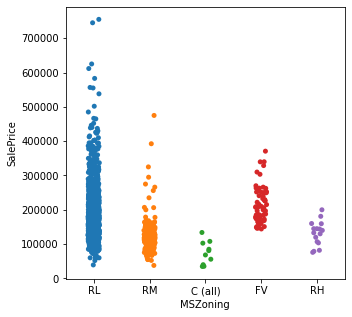

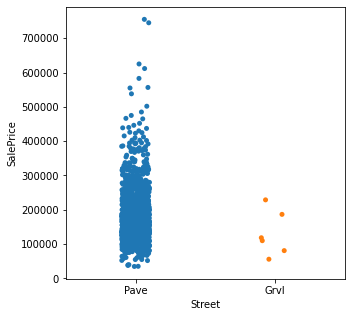

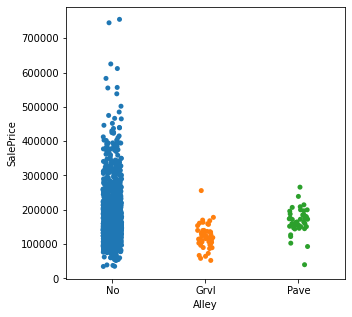

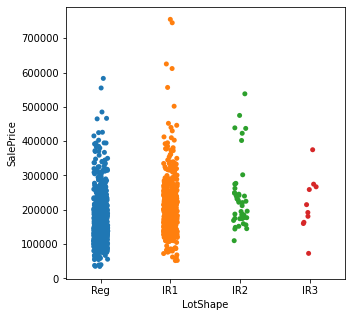

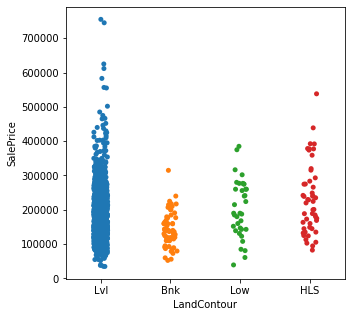

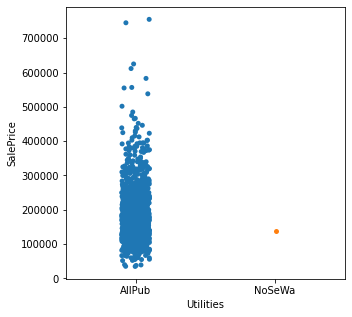

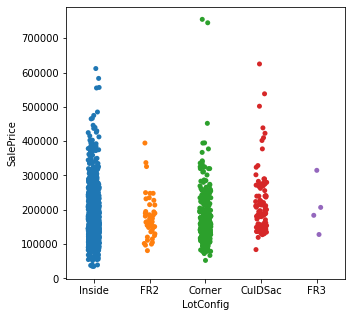

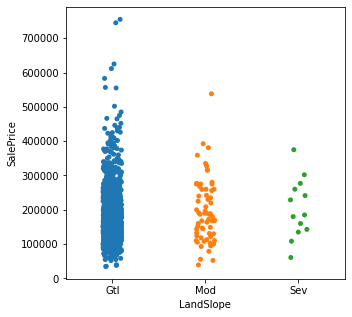

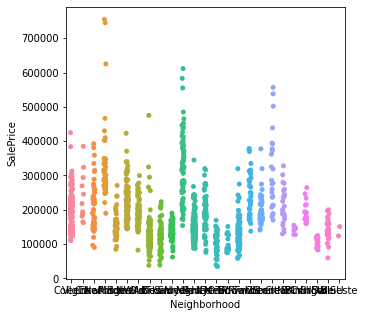

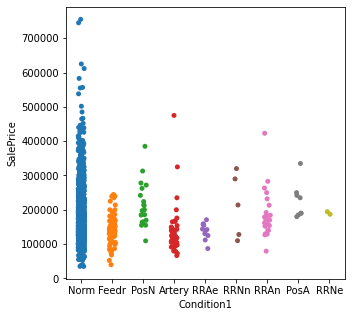

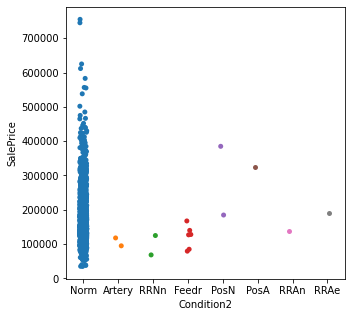

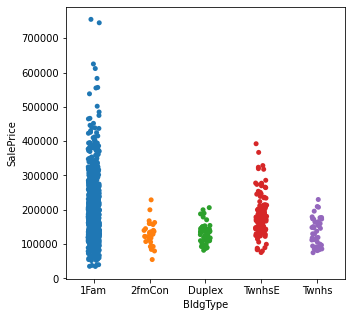

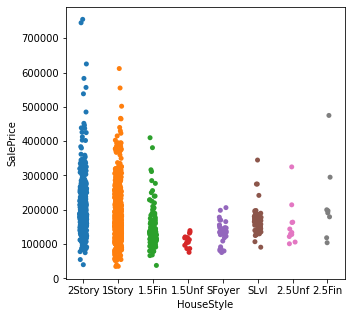

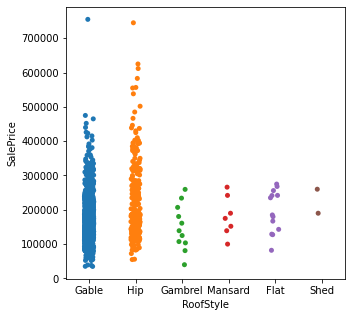

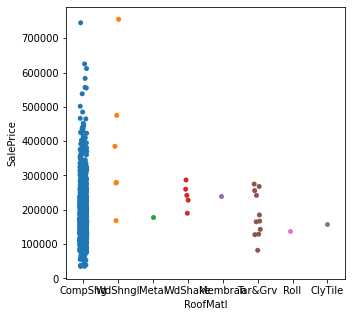

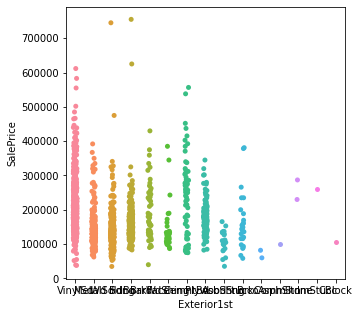

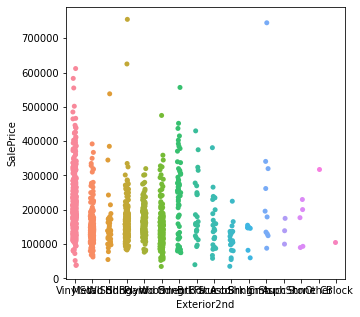

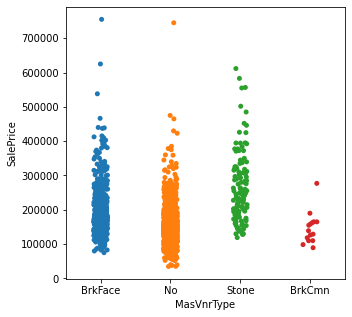

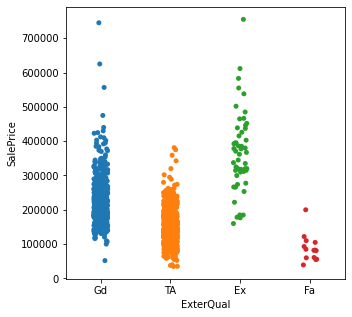

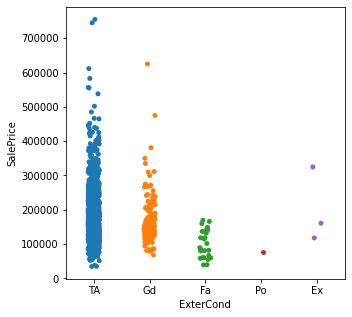

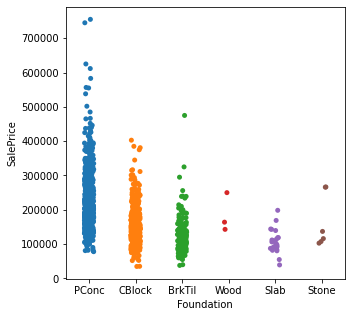

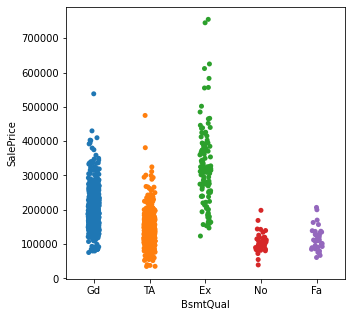

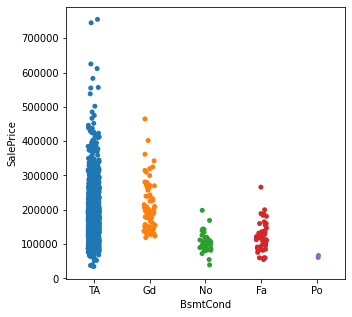

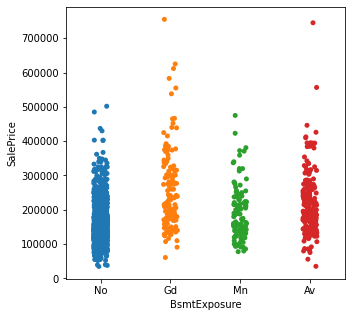

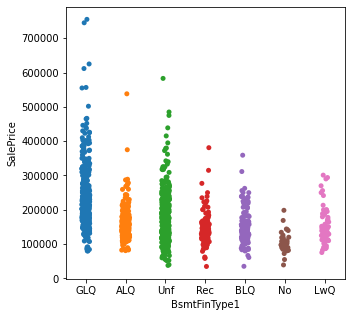

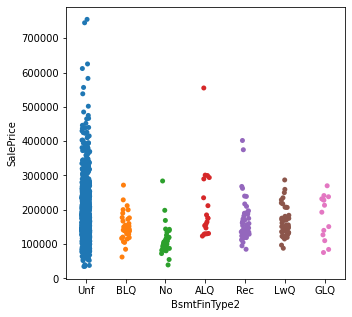

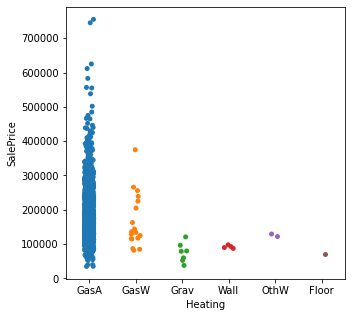

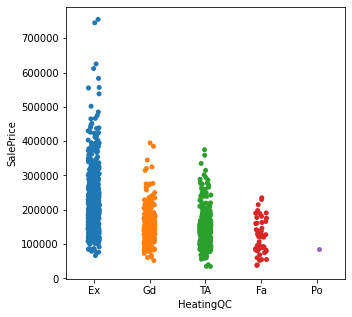

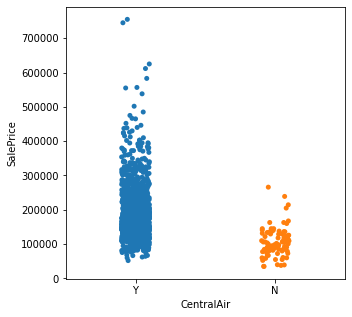

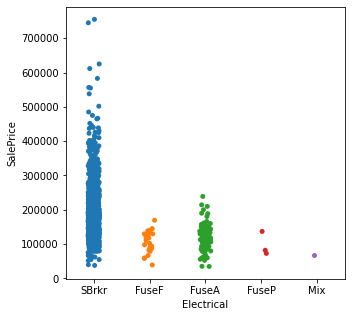

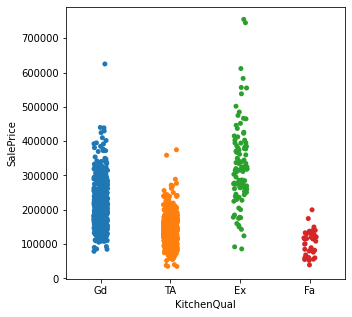

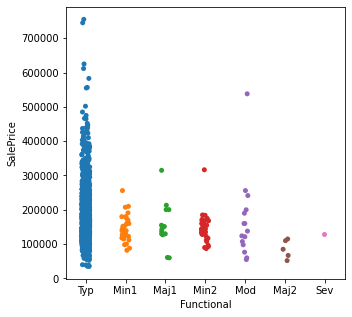

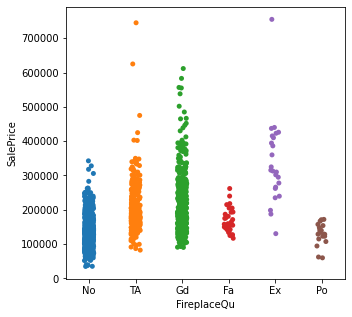

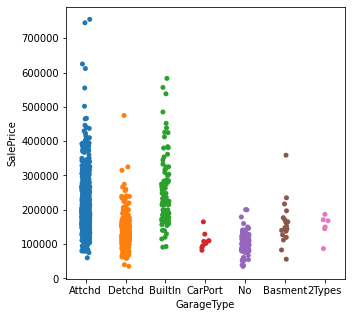

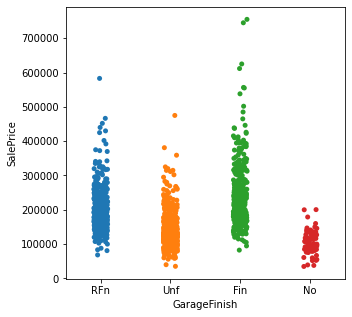

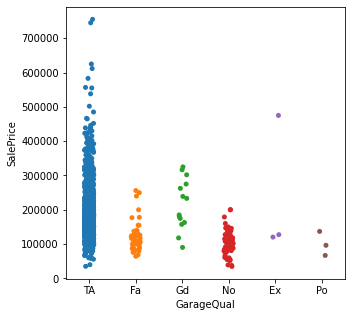

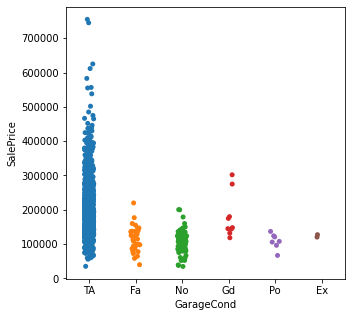

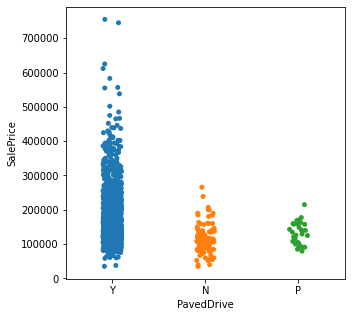

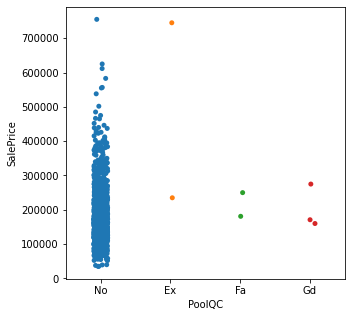

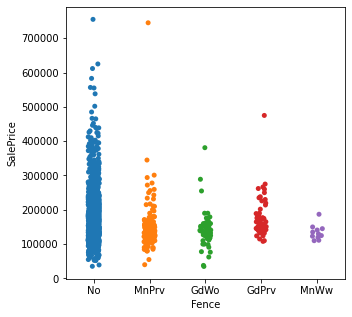

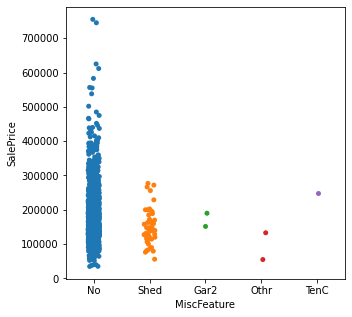

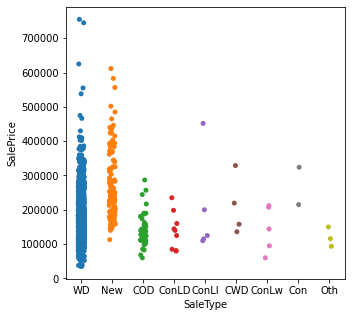

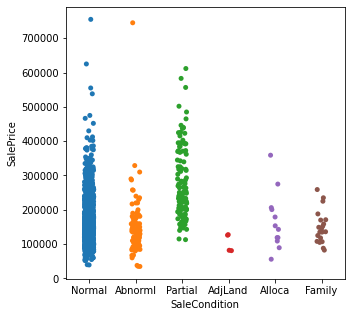

In [25]:
for idx, col in enumerate(categorical_features):
    plt.figure(idx, figsize=(5,5))
    sns.stripplot(x=col , y='SalePrice' , data = data[data.group == "Train"])
    plt.show

In [26]:
train_data = data[data.group == "Train"]
train_data_categorical = train_data.loc[:,:'SaleCondition'][categorical_features]
train_data_target = train_data['SalePrice']

X = train_data_categorical
y = train_data_target

for col in X.columns:
    X[col],_= X[col].factorize()

miscore = mutual_info_regression(X, y, random_state=25)
miscore = pd.Series(miscore, name="MISCORE", index = X.columns)
miscore = miscore.sort_values(ascending=False)

pd.DataFrame(miscore)

MISCORE
BsmtQual       0.325363
ExterQual      0.320360
KitchenQual    0.313538
GarageFinish   0.268640
Foundation     0.208497
HeatingQC      0.167333
MSZoning       0.133596
Neighborhood   0.124363
FireplaceQu    0.115822
MasVnrType     0.097565
LotShape       0.084951
GarageCond     0.083956
SaleCondition  0.080022
GarageQual     0.078373
Exterior2nd    0.075247
SaleType       0.073978
BsmtFinType1   0.071811
GarageType     0.071217
PavedDrive     0.062084
CentralAir     0.059348
Fence          0.051415
HouseStyle     0.048067
Electrical     0.042033
BldgType       0.035737
BsmtCond       0.035460
LotConfig      0.024797
BsmtFinType2   0.024756
Exterior1st    0.024054
Condition1     0.022206
LandContour    0.022141
Heating        0.021737
Alley          0.019695
ExterCond      0.019620
RoofStyle      0.010685
MiscFeature    0.007629
LandSlope      0.007484
BsmtExposure   0.006308
RoofMatl       0.006268
Condition2     0.001546
Utilities      0.000950
Street         0.000000
Functional     0.000000
PoolQC         0.000000

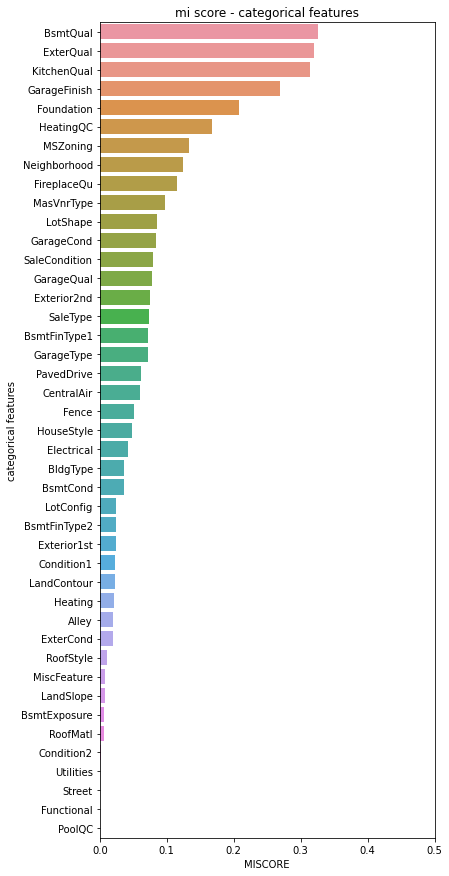

In [27]:
mi = pd.DataFrame(miscore)
fig, ax = plt.subplots(figsize=(6,15))

ax.set_title("mi score - categorical features")
sns.barplot(data=mi, y=mi.index, x='MISCORE', ax=ax)
ax.set_ylabel("categorical features")
ax.set_xlim(0,0.5)
plt.show;

In accordance to mi scores and plots these categorical features are uninformative for target feature prediction and therefore should be modified or dropped:

PavedDrive,
CentralAir,
Fence,
HouseStyle,
Electrical,
BldgType,
BsmtCond,
LotConfig,
BsmtFinType2,
Exterior1st,
Condition1,
LandContour,
Heating,
Alley,
ExterCond,
RoofStyle,
MiscFeature,
LandSlope,
BsmtExposure,
RoofMatl,
Condition2,
Utilities,
Functional,
PoolQC,
Street

### Feature engineering


In [28]:
# new feature for ground live area on the first floor
data['GrndLivAreaFrstFlr'] = data['GrLivArea']/data['1stFlrSF']

# number of porches
data['Porchtypes'] = data[['ScreenPorch','3SsnPorch','EnclosedPorch','OpenPorchSF'\
                           ,'WoodDeckSF']].gt(0).sum(axis=1)

# number of bathrooms 
data['Totalbath'] = (data['HalfBath'] + data['FullBath'] + data['BsmtHalfBath'] + data['BsmtFullBath'])

# feature for the 2nd floor
data['2nd_flr'] = np.where(data['2ndFlrSF'].map(lambda x: x>0), 1 ,0) 

### Drop uninformative data


In [29]:
columns_to_drop = ['Fireplaces', 'HalfBath', 'KitchenAbvGr', 'EnclosedPorch','ScreenPorch',\
                   'BsmtFullBath', 'OpenPorchSF', 'WoodDeckSF', 'FullBath', '2ndFlrSF',\
                   'YrSold', 'LowQualFinSF', 'MiscVal', 'BsmtHalfBath', 'PoolArea', 'BsmtFinSF2',\
                   'MoSold', '3SsnPorch', 'PavedDrive', 'CentralAir', 'Fence', 'HouseStyle',\
                   'Electrical', 'BldgType', 'BsmtCond', 'LotConfig', 'BsmtFinType2', 'Exterior1st',\
                   'Condition1', 'LandContour', 'Heating', 'Alley', 'ExterCond', 'RoofStyle',\
                   'MiscFeature', 'LandSlope', 'BsmtExposure', 'RoofMatl', 'Condition2', 'Utilities',\
                   'Functional', 'PoolQC', 'Street']

data = data.drop(columns_to_drop, axis=1)

### New corrmatrix


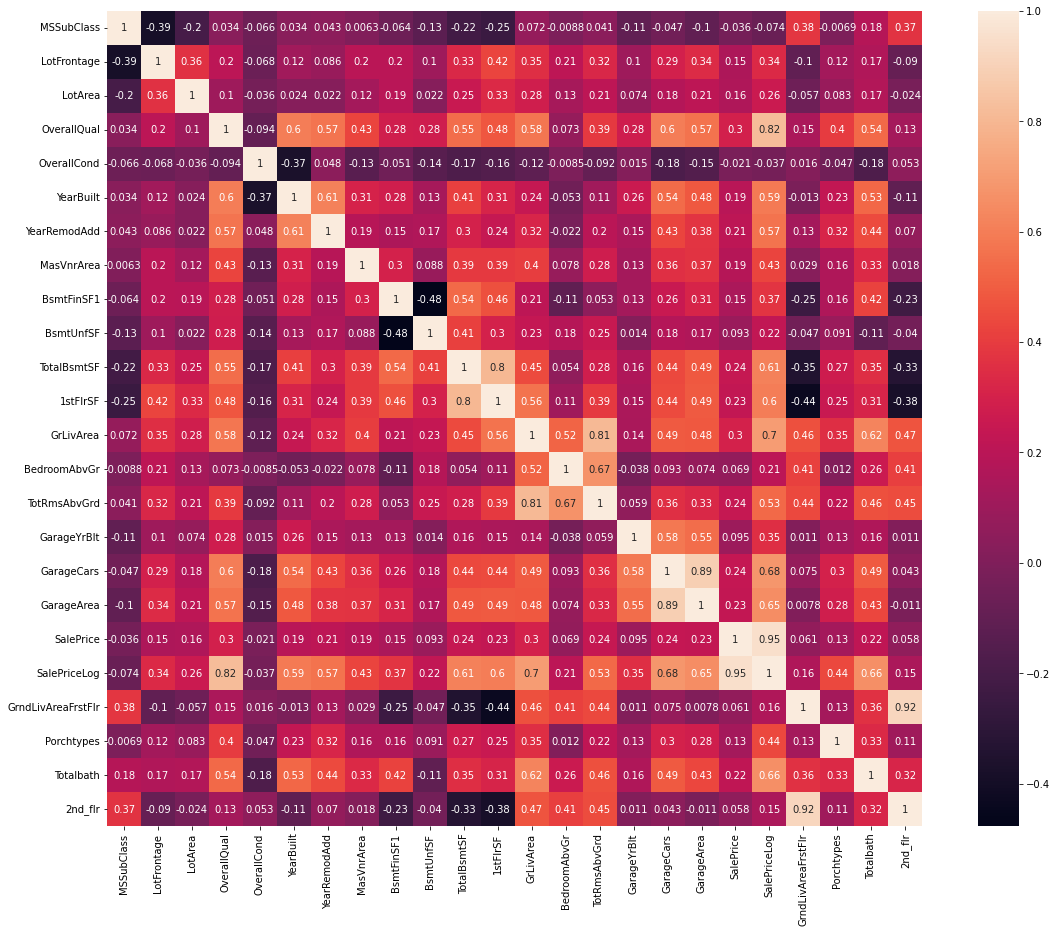

In [30]:
# looks much better
corrmatrix = data.corr()
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmatrix, annot=True, vmax=1, square=True);

### Label encoding for categorical features

In [31]:
data_train_saleprice = data[data.group=='Train']['SalePrice']
data_train_salepricelog = data[data.group=='Train']['SalePriceLog']

In [32]:
data_train = data[data.group=='Train'].drop(['group', 'SalePrice', 'SalePriceLog'], axis=1)


data_test_saleprice = data[data.group=='Test']['SalePrice']
data_test_salepricelog = data[data.group=='Test']['SalePriceLog']

data_test = data[data.group=='Test'].drop(['group', 'SalePrice', 'SalePriceLog'], axis=1)
#

In [33]:
# 1st train dataset
data_train_encoded = data_train.copy()
#
categorical_features = [col for col in data_train_encoded.columns if
                    data_train_encoded[col].dtype == "object"]
for i in categorical_features:
    label = LabelEncoder()
    label.fit(data_train_encoded[i].values)
    data_train_encoded[i] = label.transform(data_train_encoded[i].values)
    
# 1st test dataset
data_test_encoded = data_test.copy()
#
categorical_features = [col for col in data_test_encoded.columns if
                    data_test_encoded[col].dtype == "object"]
for i in categorical_features:
    label.fit(data_test_encoded[i].values)
    data_test_encoded[i] = label.transform(data_test_encoded[i].values)

In [34]:
data_test_encoded

MSSubClass  MSZoning  LotFrontage  LotArea  LotShape  Neighborhood  OverallQual  OverallCond  YearBuilt  YearRemodAdd  Exterior2nd  MasVnrType  MasVnrArea  ExterQual  Foundation  BsmtQual  BsmtFinType1  BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  HeatingQC  1stFlrSF  GrLivArea  BedroomAbvGr  KitchenQual  TotRmsAbvGrd  FireplaceQu  GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond  SaleType  SaleCondition  GrndLivAreaFrstFlr  Porchtypes  Totalbath  2nd_flr
1460          20         2         80.0    11622         3            12            5            6       1961          1961           12           2         0.0          3           1         4             5       468.0      270.0        882.0          4       896        896             2            3             5            3           1       1961.0             3         1.0       730.0           4           5         8              4            1.000000           2        1.0        0
1461          20         3         81.0    14267         0            12            6            6       1958          1958           13           1       108.0          3           1         4             0       923.0      406.0       1329.0          4      1329       1329             3            2             6            3           1       1958.0             3         1.0       312.0           4           5         8              4            1.000000           2        2.0        0
1462          60         3         74.0    13830         0             8            5            5       1997          1998           12           2         0.0          3           2         2             2       791.0      137.0        928.0          2       928       1629             3            3             6            5           1       1997.0             0         2.0       482.0           4           5         8              4            1.755388           2        3.0        1
1463          60         3         78.0     9978         0             8            6            6       1998          1998           12           1        20.0          3           2         4             2       602.0      324.0        926.0          0       926       1604             3            2             7            2           1       1998.0             0         2.0       470.0           4           5         8              4            1.732181           2        3.0        1
1464         120         3         43.0     5005         0            22            8            5       1992          1992            6           2         0.0          2           2         2             0       263.0     1017.0       1280.0          0      1280       1280             2            2             5            3           1       1992.0             2         2.0       506.0           4           5         8              4            1.000000           2        2.0        0
...          ...       ...          ...      ...       ...           ...          ...          ...        ...           ...          ...         ...         ...        ...         ...       ...           ...         ...        ...          ...        ...       ...        ...           ...          ...           ...          ...         ...          ...           ...         ...         ...         ...         ...       ...            ...                 ...         ...        ...      ...
2914         160         4         21.0     1936         3            10            4            7       1970          1970            5           2         0.0          3           1         4             6         0.0      546.0        546.0          2       546       1092             3            3             5            3           6          0.0             1         0.0         0.0           2           3         8              4            2.000000           0        2.0        1
2915         160         4         21.0     1894      

### Scaling

Due to a high variety in columns values magnitudes it is recommended to normalise data

In [35]:
# 2nd train dataset
data_train_encoded_normalised = data_train_encoded.copy()
data_train_encoded_normalised = MinMaxScaler().fit_transform(data_train_encoded_normalised)

# 2nd test dataset
data_test_encoded_normalised = data_test_encoded.copy()
data_test_encoded_normalised = MinMaxScaler().fit_transform(data_test_encoded_normalised)


# Models training


### Different combinations of train_test split for features encoded and normalised datasets. All with a train_size = 0.8

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data_train,data_train_saleprice, train_size=0.8,\
                                                    test_size=0.2,random_state=25)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(data_train,data_train_salepricelog,\
                        train_size=0.8, test_size=0.2,random_state=25)

Train-test split

In [37]:
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = \
    train_test_split(data_train_encoded, data_train_saleprice, train_size=0.8, test_size=0.2,\
                     random_state=25)

X_train_encoded_log, X_test_encoded_log, y_train_encoded_log, y_test_encoded_log = \
    train_test_split(data_train_encoded, data_train_salepricelog, train_size=0.8, test_size=0.2,\
                     random_state=25)

In [38]:
X_train_encoded_normalised, X_test_encoded_normalised, y_train_encoded_normalised,\
    y_test_encoded_normalised = train_test_split(data_train_encoded_normalised,data_train_saleprice,\
                                train_size=0.8, test_size=0.2,random_state=25)

X_train_encoded_normalised_log, X_test_encoded_normalised_log, y_train_encoded_normalised_log,\
    y_test_encoded_normalised_log = train_test_split(data_train_encoded_normalised, data_train_salepricelog,\
                                train_size=0.8, test_size=0.2,random_state=25)

# GridSearchCV for the best model parameters

### RandomForestRegressor


In [39]:
rfr = RandomForestRegressor()

params1 = {'n_estimators':[100,300,500],
          'max_depth':[10,15,20],
          'max_leaf_nodes':[50,100,150]
         }

cv1 = GridSearchCV(rfr, params1, cv=5, scoring = 'neg_mean_absolute_error')
cv1.fit(X_train_encoded, y_train_encoded)

print(cv1.best_params_)

{'max_depth': 20, 'max_leaf_nodes': 150, 'n_estimators': 300}


In [40]:
cv2 = GridSearchCV(rfr, params1, cv=5, scoring = 'neg_mean_absolute_error')
cv2.fit(X_train_encoded_log, y_train_encoded_log)

print(cv2.best_params_)

{'max_depth': 15, 'max_leaf_nodes': 150, 'n_estimators': 300}


In [41]:
cv3 = GridSearchCV(rfr, params1, cv=5, scoring = 'neg_mean_absolute_error')
cv3.fit(X_train_encoded_normalised, y_train_encoded_log)

print(cv3.best_params_)

{'max_depth': 15, 'max_leaf_nodes': 150, 'n_estimators': 500}


In [42]:
cv4 = GridSearchCV(rfr, params1, cv=5, scoring = 'neg_mean_absolute_error')
cv4.fit(X_train_encoded_normalised_log, y_train_encoded_normalised_log)

print(cv4.best_params_)

{'max_depth': 20, 'max_leaf_nodes': 150, 'n_estimators': 300}


### XGBRegressor

In [43]:
xgb = XGBRegressor()

params2 = {'n_estimators':[100,500,1000],
          'max_depth':[3,4,5],
          'learning_rate':[0.01,0.5,0.8]}

cv5 = GridSearchCV(xgb, params2, cv=5, verbose = 0, scoring='neg_mean_absolute_error')
cv5.fit(X_train_encoded, y_train_encoded)

print(cv5.best_params_)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}


In [44]:
cv6 = GridSearchCV(xgb, params2, cv=5, verbose = 0, scoring='neg_mean_absolute_error')
cv6.fit(X_train_encoded_log, y_train_encoded_log)

print(cv6.best_params_)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}


In [45]:
cv7 = GridSearchCV(xgb, params2, cv=5, scoring = 'neg_mean_absolute_error')
cv7.fit(X_train_encoded_normalised, y_train_encoded_normalised)

print(cv7.best_params_)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}


In [46]:
cv8 = GridSearchCV(xgb, params2, cv=5, scoring = 'neg_mean_absolute_error')
cv8.fit(X_train_encoded_normalised_log, y_train_encoded_normalised_log)

print(cv8.best_params_)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}


### Ridge/Lasso

In [47]:
rdg = Ridge()

params3 = {'alpha': [1, 10, 100, 200, 1000]}

cv9 = GridSearchCV(rdg, params3, cv=5, verbose = 0, scoring='neg_mean_absolute_error')
cv9.fit(X_train_encoded, y_train_encoded)

print(cv9.best_params_)
ridge_score = cv9.best_score_
print(ridge_score) 

{'alpha': 200}
-20014.247163331584


In [48]:
cv10 = GridSearchCV(rdg, params3, cv=5, verbose = 0, scoring='neg_mean_absolute_error')
cv10.fit(X_train_encoded_log, y_train_encoded_log)

print(cv10.best_params_)
ridge_score = cv10.best_score_
print(ridge_score) 

{'alpha': 200}
-0.1009973280520026


In [49]:
cv11 = GridSearchCV(rdg, params3, cv=5, verbose = 0, scoring='neg_mean_absolute_error')
cv11.fit(X_train_encoded_normalised, y_train_encoded_normalised)

print(cv11.best_params_)
ridge_score = cv11.best_score_
print(ridge_score) 

{'alpha': 1}
-20748.98578737356


In [50]:
cv12 = GridSearchCV(rdg, params3, cv=5, verbose = 0, scoring='neg_mean_absolute_error')
cv12.fit(X_train_encoded_normalised_log, y_train_encoded_normalised_log)

print(cv12.best_params_)
ridge_score = cv12.best_score_
print(ridge_score) 

{'alpha': 1}
-0.10472200925247799


In [51]:
ls = Lasso()
cv13 = GridSearchCV(ls, params3, cv=5, verbose = 0, scoring='neg_mean_absolute_error')
cv13.fit(X_train_encoded, y_train_encoded)

print(cv13.best_params_)
lasso_score = cv13.best_score_
print(lasso_score) 

{'alpha': 1000}
-20071.174229852033


In [52]:
cv14 = GridSearchCV(ls, params3, cv=5, verbose = 0, scoring='neg_mean_absolute_error')
cv14.fit(X_train_encoded_log, y_train_encoded_log)

print(cv14.best_params_)
lasso_score = cv14.best_score_
print(lasso_score) 

{'alpha': 1}
-0.12953539355152305


In [53]:
cv15 = GridSearchCV(ls, params3, cv=5, verbose = 0, scoring='neg_mean_absolute_error')
cv15.fit(X_train_encoded_normalised, y_train_encoded_normalised)

print(cv15.best_params_)
lasso_score = cv15.best_score_
print(lasso_score) 

{'alpha': 100}
-20455.037343658278


In [54]:
cv16 = GridSearchCV(ls, params3, cv=5, verbose = 0, scoring='neg_mean_absolute_error')
cv16.fit(X_train_encoded_normalised_log, y_train_encoded_normalised_log)

print(cv16.best_params_)
lasso_score = cv16.best_score_
print(lasso_score) 

{'alpha': 1}
-0.30890791824955544


### CatboostRegressor

In [55]:
ctb = CatBoostRegressor()

params4 = {'depth':[1, 5, 10],
          'iterations':[10, 30, 50],
          'learning_rate':[0.1, 0.3], 
          'l2_leaf_reg':[1,5,10]}

cv17 = GridSearchCV(ctb, params4, cv=5, verbose = 0, scoring='neg_mean_absolute_error')
cv17.fit(X_train_encoded, y_train_encoded)

print(cv17.best_params_)

0:	learn: 71369.0637734	total: 55.5ms	remaining: 499ms
1:	learn: 68440.8977897	total: 56.5ms	remaining: 226ms
2:	learn: 65638.1216226	total: 56.8ms	remaining: 132ms
3:	learn: 63372.6516888	total: 57.2ms	remaining: 85.8ms
4:	learn: 61470.9989802	total: 57.6ms	remaining: 57.6ms
5:	learn: 59372.3361940	total: 58.1ms	remaining: 38.7ms
6:	learn: 57614.1758863	total: 58.5ms	remaining: 25.1ms
7:	learn: 56188.7532393	total: 59ms	remaining: 14.7ms
8:	learn: 54680.4103572	total: 59.3ms	remaining: 6.59ms
9:	learn: 53126.3293705	total: 59.7ms	remaining: 0us
0:	learn: 74887.5611589	total: 398us	remaining: 3.59ms
1:	learn: 72057.8613553	total: 951us	remaining: 3.8ms
2:	learn: 69042.4082223	total: 1.33ms	remaining: 3.12ms
3:	learn: 66496.4850112	total: 1.75ms	remaining: 2.63ms
4:	learn: 64642.3149094	total: 2.12ms	remaining: 2.12ms
5:	learn: 62576.8565593	total: 2.53ms	remaining: 1.69ms
6:	learn: 61014.6157528	total: 2.91ms	remaining: 1.25ms
7:	learn: 59509.3796968	total: 3.32ms	remaining: 829us
8:	l

In [56]:
cv18 = GridSearchCV(ctb, params4, cv=5, verbose = 0, scoring='neg_mean_absolute_error', n_jobs=-1)
cv18.fit(X_train_encoded_log, y_train_encoded_log)

print(cv18.best_params_)

0:	learn: 0.3812098	total: 47.4ms	remaining: 427ms
1:	learn: 0.3674841	total: 47.9ms	remaining: 192ms
2:	learn: 0.3567054	total: 48.4ms	remaining: 113ms
3:	learn: 0.3436620	total: 48.8ms	remaining: 73.1ms
4:	learn: 0.3332678	total: 53.8ms	remaining: 53.8ms
5:	learn: 0.3237720	total: 54.1ms	remaining: 36.1ms
6:	learn: 0.3138777	total: 54.5ms	remaining: 23.3ms
7:	learn: 0.3062069	total: 54.8ms	remaining: 13.7ms
8:	learn: 0.2992075	total: 55.6ms	remaining: 6.17ms
9:	learn: 0.2910070	total: 56.1ms	remaining: 0us
0:	learn: 0.3475900	total: 864us	remaining: 7.78ms
1:	learn: 0.3156326	total: 2.3ms	remaining: 9.2ms
2:	learn: 0.2953443	total: 3.04ms	remaining: 7.1ms
3:	learn: 0.2766216	total: 3.75ms	remaining: 5.62ms
4:	learn: 0.2588386	total: 6.39ms	remaining: 6.39ms
5:	learn: 0.2419535	total: 6.99ms	remaining: 4.66ms
6:	learn: 0.2307150	total: 7.44ms	remaining: 3.19ms
7:	learn: 0.2221467	total: 7.87ms	remaining: 1.97ms
8:	learn: 0.2139104	total: 8.34ms	remaining: 926us
9:	learn: 0.2078560	tot

In [57]:
cv19 = GridSearchCV(ctb, params4, cv=5, verbose = 0, scoring='neg_mean_absolute_error', n_jobs=-1)
cv19.fit(X_train_encoded_normalised, y_train_encoded_normalised)

print(cv19.best_params_)

25:	learn: 0.0834575	total: 1.79s	remaining: 1.66s
26:	learn: 0.0813591	total: 1.85s	remaining: 1.58s
27:	learn: 0.0791999	total: 1.93s	remaining: 1.51s
28:	learn: 0.0769579	total: 1.98s	remaining: 1.44s
29:	learn: 0.0760436	total: 2.08s	remaining: 1.39s
30:	learn: 0.0735142	total: 2.17s	remaining: 1.33s
31:	learn: 0.0723692	total: 2.26s	remaining: 1.27s
32:	learn: 0.0712967	total: 2.34s	remaining: 1.21s
33:	learn: 0.0696438	total: 2.41s	remaining: 1.13s
34:	learn: 0.0692142	total: 2.43s	remaining: 1.04s
35:	learn: 0.0678850	total: 2.54s	remaining: 987ms
36:	learn: 0.0664586	total: 2.6s	remaining: 912ms
37:	learn: 0.0640121	total: 2.66s	remaining: 842ms
38:	learn: 0.0637413	total: 2.72s	remaining: 768ms
39:	learn: 0.0625458	total: 2.78s	remaining: 695ms
40:	learn: 0.0623684	total: 2.79s	remaining: 612ms
41:	learn: 0.0611712	total: 2.85s	remaining: 544ms
42:	learn: 0.0609193	total: 2.92s	remaining: 476ms
43:	learn: 0.0607265	total: 2.92s	remaining: 399ms
44:	learn: 0.0589413	total: 2.98

In [58]:
cv20 = GridSearchCV(ctb, params4, cv=5, verbose = 0, scoring='neg_mean_absolute_error', n_jobs=-1)
cv20.fit(X_train_encoded_normalised_log, y_train_encoded_normalised_log)

print(cv20.best_params_)

20:	learn: 34778.5891463	total: 1.58s	remaining: 2.19s
21:	learn: 34026.0482208	total: 1.65s	remaining: 2.1s
22:	learn: 33362.1588149	total: 1.76s	remaining: 2.07s
23:	learn: 32651.1062467	total: 1.8s	remaining: 1.95s
24:	learn: 32048.8550503	total: 1.87s	remaining: 1.87s
25:	learn: 31382.3039608	total: 1.96s	remaining: 1.81s
26:	learn: 30783.2679031	total: 2.06s	remaining: 1.75s
27:	learn: 30255.3141622	total: 2.12s	remaining: 1.67s
28:	learn: 29748.3031374	total: 2.21s	remaining: 1.6s
29:	learn: 29239.6241738	total: 2.27s	remaining: 1.52s
30:	learn: 28714.3433365	total: 2.31s	remaining: 1.42s
31:	learn: 28235.5493003	total: 2.4s	remaining: 1.35s
32:	learn: 27747.8755888	total: 2.4s	remaining: 1.24s
33:	learn: 27347.2694887	total: 2.45s	remaining: 1.15s
34:	learn: 26916.1193384	total: 2.55s	remaining: 1.09s
35:	learn: 26523.7095007	total: 2.64s	remaining: 1.03s
36:	learn: 26240.7846906	total: 2.71s	remaining: 951ms
37:	learn: 25976.9670039	total: 2.75s	remaining: 868ms
38:	learn: 2559

# Prediction


### RandomForestRegressor


In [59]:
rfr_model_1 = RandomForestRegressor(max_depth=15, max_leaf_nodes=150, n_estimators=100, random_state=25)\
            .fit(X_train_encoded,  y_train_encoded)
rfr_model_2 = RandomForestRegressor(max_depth=15, max_leaf_nodes=150, n_estimators=300, random_state=25)\
            .fit(X_train_encoded_log,  y_train_encoded_log)
rfr_model_3 = RandomForestRegressor(max_depth=15, max_leaf_nodes=150, n_estimators=300, random_state=25)\
            .fit(X_train_encoded_normalised,  y_train_encoded_normalised)
rfr_model_4 = RandomForestRegressor(max_depth=20, max_leaf_nodes=150, n_estimators=500, random_state=25)\
            .fit(X_train_encoded_normalised_log,  y_train_encoded_normalised_log)

### XGBRegressor

In [60]:
xgb_model_1 = XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=1000, random_state=25)\
                .fit(X_train_encoded,  y_train_encoded)
xgb_model_2 = XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=1000, random_state=25)\
                .fit(X_train_encoded_log,  y_train_encoded_log)
xgb_model_3 = XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=1000, random_state=25)\
                .fit(X_train_encoded_normalised,  y_train_encoded_normalised)
xgb_model_4 = XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=1000, random_state=25)\
                .fit(X_train_encoded_normalised_log,  y_train_encoded_normalised_log)

### Lasso/Ridge

In [61]:
ridge_model_1 = Ridge(alpha=200, random_state=25).fit(X_train_encoded,y_train_encoded)
ridge_model_2 = Ridge(alpha=200, random_state=25).fit(X_train_encoded_log,y_train_encoded_log)
ridge_model_3 = Ridge(alpha=1, random_state=25).fit(X_train_encoded_normalised\
                                                    ,y_train_encoded_normalised)
ridge_model_4 = Ridge(alpha=1, random_state=25).fit(X_train_encoded_normalised_log\
                                                    ,y_train_encoded_normalised_log)

In [62]:
lasso_model_1 = Lasso(alpha=1000, max_iter=10000, random_state=25).fit(X_train_encoded,y_train_encoded)
lasso_model_2 = Lasso(alpha=1, max_iter=10000, random_state=25).fit(X_train_encoded_log,y_train_encoded_log)
lasso_model_3 = Lasso(alpha=100, max_iter=10000, random_state=25).fit(X_train_encoded_normalised\
                                                    ,y_train_encoded_normalised)
lasso_model_4 = Lasso(alpha=1, max_iter=10000, random_state=25).fit(X_train_encoded_normalised_log\
                                                    ,y_train_encoded_normalised_log)

### CatboostRegressor

In [63]:
cbregressor_model_1 = CatBoostRegressor(depth=5, iterations=50, l2_leaf_reg=1,\
                    learning_rate=0.3, random_state=25).fit(X_train_encoded,y_train_encoded)

cbregressor_model_2 = CatBoostRegressor(depth=5, iterations=50, l2_leaf_reg=5,\
                    learning_rate=0.3, random_state=25).fit(X_train_encoded_log,y_train_encoded_log)

cbregressor_model_3 = CatBoostRegressor(depth=5, iterations=50, l2_leaf_reg=1,\
        learning_rate=0.3, random_state=25).fit(X_train_encoded_normalised,y_train_encoded_normalised)

cbregressor_model_4 = CatBoostRegressor(depth=5, iterations=50, l2_leaf_reg=5,\
learning_rate=0.3, random_state=25).fit(X_train_encoded_normalised_log,y_train_encoded_normalised_log)

0:	learn: 62813.7253881	total: 1.63ms	remaining: 79.9ms
1:	learn: 51527.7245720	total: 3.81ms	remaining: 91.6ms
2:	learn: 44328.7478346	total: 6.36ms	remaining: 99.6ms
3:	learn: 39670.1547772	total: 7.77ms	remaining: 89.4ms
4:	learn: 35992.7350911	total: 9.32ms	remaining: 83.9ms
5:	learn: 33440.8371674	total: 10.9ms	remaining: 80.1ms
6:	learn: 31793.0374775	total: 12.5ms	remaining: 76.9ms
7:	learn: 29433.0024781	total: 14ms	remaining: 73.4ms
8:	learn: 27961.5624246	total: 15.5ms	remaining: 70.4ms
9:	learn: 26309.0798478	total: 17ms	remaining: 67.9ms
10:	learn: 25530.0322134	total: 18.5ms	remaining: 65.5ms
11:	learn: 24990.5168213	total: 20ms	remaining: 63.3ms
12:	learn: 24085.2630795	total: 21.5ms	remaining: 61.3ms
13:	learn: 23430.9387770	total: 23ms	remaining: 59.3ms
14:	learn: 22528.8751044	total: 24.6ms	remaining: 57.5ms
15:	learn: 21960.2223031	total: 26.1ms	remaining: 55.5ms
16:	learn: 21508.8173892	total: 27.7ms	remaining: 53.8ms
17:	learn: 21238.3157285	total: 29.4ms	remaining:

In [64]:
models = [rfr_model_1,rfr_model_2,rfr_model_3,rfr_model_4,\
          xgb_model_1, xgb_model_2, xgb_model_3, xgb_model_4,\
         ridge_model_1, ridge_model_2, ridge_model_3, ridge_model_4,\
         lasso_model_1, lasso_model_2, lasso_model_3, lasso_model_4,\
          cbregressor_model_1, cbregressor_model_2, cbregressor_model_3, cbregressor_model_4]

model_names = ['RF_encoded', 'RF_encoded_log', 'RF_encoded_norm', 'RF_encoded_norm_log',\
               'XGB_encoded', 'XGB_encoded_log', 'XGB_encoded_norm', 'XGB_encoded_norm_log',\
               'ridge_encoded', 'ridge_encoded_log', 'ridge_encoded_norm', 'ridge_encoded_norm_log',\
               'lasso_encoded', 'lasso_encoded_log', 'lasso_encoded_norm', 'lasso_encoded_norm_log',\
               'Cbost_encoded', 'Cbost_encoded_log', 'Cbost_encoded_norm', 'Cbost_encoded_norm_log']

In [65]:
models_encoded = [rfr_model_1, xgb_model_1, ridge_model_1, lasso_model_1, cbregressor_model_1]
models_encoded_log = [rfr_model_2, xgb_model_2, ridge_model_2, lasso_model_2, cbregressor_model_2]
models_encoded_norm = [rfr_model_3, xgb_model_3, ridge_model_3, lasso_model_3, cbregressor_model_3]
models_encoded_norm_log = [rfr_model_4, xgb_model_4, ridge_model_4, lasso_model_4, cbregressor_model_4]

model_names_encoded = ['RF_encoded', 'XGB_encoded', 'ridge_encoded', 'lasso_encoded','Cboost_encoded']
model_names_encoded_log = ['RF_encoded_log','XGB_encoded_log','ridge_encoded_log',\
                           'lasso_encoded_log','Cbost_encoded_log']
model_names_encoded_norm = ['RF_encoded_norm','XGB_encoded_norm','ridge_encoded_norm',\
                            'lasso_encoded_norm','Cbost_encoded_norm']
model_names_encoded_norm_log = ['RF_encoded_norm_log','XGB_encoded_norm_log', 'ridge_encoded_norm_log', 'lasso_encoded_norm_log',\
                                'Cbost_encoded_norm_log']

### Scores of models with encoded categories to predict price


In [66]:
scoreList_encoded = []

for i, m in enumerate(models_encoded):
    score = [model_names_encoded[i]]
    score.append(m.score(X_train_encoded,y_train_encoded))
    score.append(m.score(X_test_encoded,y_test_encoded))
    score.append(np.sqrt(mean_squared_error(np.log(y_train_encoded),np.log(m.predict(X_train_encoded)))))
    score.append(np.sqrt(mean_squared_error(np.log(y_test_encoded),np.log(m.predict(X_test_encoded)))))
    scoreList_encoded.append(score)

stats1 = pd.DataFrame(scoreList_encoded, columns = ['model', 'train_score', 'test_score', 'train RMSE', 'test RMSE'])
stats1.sort_values(['test RMSE'], ascending = True, inplace = True)
stats1.reset_index(drop=True, inplace=True)
stats1

model  train_score  test_score  train RMSE  test RMSE
0     XGB_encoded     0.978842    0.827381    0.073144   0.128684
1  Cboost_encoded     0.970116    0.854994    0.086531   0.128750
2      RF_encoded     0.970641    0.873301    0.078550   0.142703
3   ridge_encoded     0.828494    0.829599    0.154529   0.145587
4   lasso_encoded     0.826176    0.830003    0.156615   0.147421

### Scores of models with encoded categories to predict price in logarithm state

In [67]:
scoreList_encoded_log = []

for i, m in enumerate(models_encoded_log):
    score = [model_names_encoded_log[i]]
    score.append(m.score(X_train_encoded_log,y_train_encoded_log))
    score.append(m.score(X_test_encoded_log,y_test_encoded_log))
    score.append(np.sqrt(mean_squared_error(np.log(y_train_encoded_log),\
                                            np.log(m.predict(X_train_encoded_log)))))
    score.append(np.sqrt(mean_squared_error(np.log(y_test_encoded_log),\
                                            np.log(m.predict(X_test_encoded_log)))))
    scoreList_encoded_log.append(score)
    
stats2 = pd.DataFrame(scoreList_encoded_log, columns = ['model', 'train_score', 'test_score', 'train RMSE', 'test RMSE'])
stats2.sort_values(['test RMSE'], ascending = True, inplace = True)
stats2.reset_index(drop=True, inplace=True)
stats2

model  train_score  test_score  train RMSE  test RMSE
0  Cbost_encoded_log     0.943092    0.907952    0.007938   0.010376
1  ridge_encoded_log     0.857404    0.901730    0.012410   0.010837
2     RF_encoded_log     0.972073    0.881697    0.005567   0.011865
3    XGB_encoded_log     0.967339    0.873054    0.006022   0.011978
4  lasso_encoded_log     0.747449    0.845298    0.016359   0.013594

### Scores of models with encoded categories and normalised features to predict price

In [68]:
scoreList_encoded_normalised = []

for i, m in enumerate(models_encoded_norm):
    score = [model_names_encoded_norm[i]]
    score.append(m.score(X_train_encoded_normalised,y_train_encoded_normalised))
    score.append(m.score(X_test_encoded_normalised,y_test_encoded_normalised))
    score.append(np.sqrt(mean_squared_error(np.log(y_train_encoded_normalised),\
                                            np.log(m.predict(X_train_encoded_normalised)))))
    score.append(np.sqrt(mean_squared_error(np.log(y_test_encoded_normalised),\
                                            np.log(m.predict(X_test_encoded_normalised)))))
    scoreList_encoded_normalised.append(score)
    
stats3 = pd.DataFrame(scoreList_encoded_normalised, columns = ['model', 'train_score', 'test_score', 'train RMSE', 'test RMSE'])
stats3.sort_values(['test RMSE'], ascending = True, inplace = True)
stats3.reset_index(drop=True, inplace=True)
stats3

model  train_score  test_score  train RMSE  test RMSE
0    XGB_encoded_norm     0.978842    0.827382    0.073144   0.128683
1  Cbost_encoded_norm     0.970116    0.854994    0.086531   0.128750
2     RF_encoded_norm     0.971964    0.873562    0.076939   0.141559
3  ridge_encoded_norm     0.830004    0.820710    0.159216   0.155460
4  lasso_encoded_norm     0.829412    0.823726    0.159010   0.155654

### Scores of models with encoded categories and normalised features to predict price in logarithm state

In [69]:
scoreList_encoded_normalised_log = []

for i, m in enumerate(models_encoded_norm_log):
    score = [model_names_encoded_norm_log[i]]
    score.append(m.score(X_train_encoded_normalised_log,y_train_encoded_normalised_log))
    score.append(m.score(X_test_encoded_normalised_log,y_test_encoded_normalised_log))
    score.append(np.sqrt(mean_squared_error(np.log(y_train_encoded_normalised_log),\
                                            np.log(m.predict(X_train_encoded_normalised_log)))))
    score.append(np.sqrt(mean_squared_error(np.log(y_test_encoded_normalised_log),\
                                            np.log(m.predict(X_test_encoded_normalised_log)))))
    scoreList_encoded_normalised_log.append(score)
    
stats4 = pd.DataFrame(scoreList_encoded_normalised_log, columns = ['model', 'train_score', 'test_score', 'train RMSE', 'test RMSE'])
stats4.sort_values(['test RMSE'], ascending = True, inplace = True)
stats4.reset_index(drop=True, inplace=True)
stats4

model  train_score  test_score  train RMSE  test RMSE
0  Cbost_encoded_norm_log     0.943092    0.907952    0.007938   0.010376
1  ridge_encoded_norm_log     0.859758    0.894432    0.012348   0.011223
2     RF_encoded_norm_log     0.972242    0.882541    0.005546   0.011834
3    XGB_encoded_norm_log     0.967339    0.873084    0.006022   0.011977
4  lasso_encoded_norm_log     0.000000   -0.008591    0.032960   0.034157

# Finally, we got results. 

CatBoostRegressor for data with encoded categorical features for logarithm of the target feature scored the best. Test score 0.907952, test RMSE 0.010376


# Time to predict

In [70]:
y_predict = cbregressor_model_2.predict(data_test_encoded)

In [71]:
y_predict

array([11.68490113, 11.99960303, 12.09640587, ..., 11.94530275,
       11.63972717, 12.23540398])

Predicted values are in the logarithm state.
To submit prediction we shall convert them through the exponential function.

In [72]:
submission_data = pd.DataFrame(np.expm1(y_predict))
submission_data['Id'] = np.arange(1461, 2920, 1)
submission_data.columns = ['SalePrice', 'Id']
cols = submission_data.columns.to_list()
cols = [cols[-1], cols[0]]
submission_data = submission_data[cols]

In [73]:
submission_data.to_csv('submission.csv', index=False)